In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [7]:
exit_notes_df = pd.read_excel(r'C:\Users\David Chaniott\Documents\Nashville Software School\python\projects\ddid-cheesecake_factory\data\TEIS Exit Data for NSS - Manual Edit.xlsx', sheet_name='Exit Notes')
eco_exit_df = pd.read_excel(r'C:\Users\David Chaniott\Documents\Nashville Software School\python\projects\ddid-cheesecake_factory\data\TEIS Exit Data for NSS - Manual Edit.xlsx', sheet_name='ECO with Exit20-21')
eco_exit_df = eco_exit_df.head(-7)

In [8]:
teis_data_df = exit_notes_df[exit_notes_df['Exit Note'].str.contains('reopened', case=False, na=False)].reset_index(drop=True)
reopened_df = teis_data_df.drop(columns=['POE', 'Notification Date', 'Initial Eligibility Date', 'Latest IFSP Date'])

In [9]:
reopened_df['Exit Note'].str.findall('(\\d{2}/\\d{2}/\\d{4})')
dates_df = reopened_df['Exit Note'].str.findall('(\\d{2}/\\d{2}/\\d{4})')
dates_df = dates_df.to_frame()

dates_df['total_dates'] = dates_df['Exit Note'].apply(lambda x: len(str(x).split(' ')))

dates_df.total_dates.describe()

reopened_df['reopened_dates'] = reopened_df['Exit Note'].str.findall('Reopened: \\d{2}/\\d{2}/\\d{4}')
reopened_df['exit_dates'] = reopened_df['Exit Note'].str.findall('Exit Date: \\d{2}/\\d{2}/\\d{4}')

reopen_date_df = reopened_df.reopened_dates.to_frame().astype(str)
exit_date_df = reopened_df.exit_dates.to_frame().astype(str)

reopen_date_df = reopen_date_df.reopened_dates.str.split(',', expand=True)
reopen_date_df.columns = ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6']
exit_date_df = exit_date_df.exit_dates.str.split(',', expand=True)
exit_date_df.columns = ['exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']

cols_r = ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6']
cols_e = ['exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']

reopen_date_df[cols_r] = reopen_date_df[cols_r].replace({'\[':'', '\]':'', '\'':'', 'Reopened:':''}, regex=True)
exit_date_df[cols_e] = exit_date_df[cols_e].replace({'\[':'', '\]':'', '\'':'', 'Exit Date:':''}, regex=True)

In [10]:
reopen_exit_date_df = reopen_date_df.join(exit_date_df)

cols_r_e =  ['reopen1', 'reopen2', 'reopen3', 'reopen4', 'reopen5', 'reopen6',
             'exit1', 'exit2', 'exit3', 'exit4', 'exit5', 'exit6']
             
reopen_exit_date_df = reopen_exit_date_df.astype('datetime64')
reopen_exit_date_df = reopen_exit_date_df.reindex(columns=['exit1', 'reopen1', 'exit2', 'reopen2', 'exit3', 'reopen3', 'exit4', 'reopen4', 'exit5', 'reopen5', 'exit6', 'reopen6'])

ifsp_date = reopened_df[['Child ID', 'DOB', 'Initial IFSP Date', 'Exit Date', 'Days from I-IFSP to Exit']]
ifsp_date[['Initial IFSP Date', 'Exit Date']].astype('datetime64')
ifsp_date['age3_date'] = ifsp_date['DOB'] + pd.offsets.DateOffset(years=3)
reopen_exit_date_df = ifsp_date.join(reopen_exit_date_df)

###IF REOPEN DATE IS AFTER 'EXIT DATE', CHANGE 'EXIT DATE' TO CURRENT DAY AND RECALCULATE 'DAYS FROM I-IFSP TO EXIT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 > reopen_exit_date_df['Exit Date'], ['Exit Date']] = pd.to_datetime('today').normalize()

###IF 'EXIT DATE' IS AFTER THEIR 3RD BIRTHDAY, CHANGE 'EXIT DATE' TO 'AGE3_DATE'
reopen_exit_date_df['Exit Date'] = np.where(reopen_exit_date_df['Exit Date'] > reopen_exit_date_df.age3_date, reopen_exit_date_df.age3_date, reopen_exit_date_df['Exit Date'])

###RECALCULATE 'DAYS FROM I-IFSP TO EXIT'
reopen_exit_date_df['Days from I-IFSP to Exit'] = reopen_exit_date_df['Exit Date'] - reopen_exit_date_df['Initial IFSP Date']

###SET 'REOPEN1' TO NULL IF THE DATE LISTED IS EQUAL TO OR AFTER 'AGE3_DATE'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 > reopen_exit_date_df.age3_date, ['reopen1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 == reopen_exit_date_df.age3_date, ['reopen1']] = 'NaT'

###SET 'REOPEN1' TO NULL IF THE DATE LISTED IS EQUAL TO 'EXIT DATE'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 == reopen_exit_date_df['Exit Date'], ['reopen1']] = 'NaT'

reopen_exit_date_df.loc[reopen_exit_date_df.exit1 < reopen_exit_date_df['Initial IFSP Date'], ['exit1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit2 < reopen_exit_date_df['Initial IFSP Date'], ['exit2']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit3 < reopen_exit_date_df['Initial IFSP Date'], ['exit3']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit4 < reopen_exit_date_df['Initial IFSP Date'], ['exit4']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit5 < reopen_exit_date_df['Initial IFSP Date'], ['exit5']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.exit6 < reopen_exit_date_df['Initial IFSP Date'], ['exit6']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen1 < reopen_exit_date_df['Initial IFSP Date'], ['reopen1']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen2 < reopen_exit_date_df['Initial IFSP Date'], ['reopen2']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen3 < reopen_exit_date_df['Initial IFSP Date'], ['reopen3']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen4 < reopen_exit_date_df['Initial IFSP Date'], ['reopen4']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen5 < reopen_exit_date_df['Initial IFSP Date'], ['reopen5']] = 'NaT'
reopen_exit_date_df.loc[reopen_exit_date_df.reopen6 < reopen_exit_date_df['Initial IFSP Date'], ['reopen6']] = 'NaT'
#
reopen_exit_date_df = reopen_exit_date_df[reopen_exit_date_df.exit1.notnull()].reset_index(drop=True)

reopen_exit_date_df.exit1 = np.where(reopen_exit_date_df.exit1 == reopen_exit_date_df['Exit Date'], reopen_exit_date_df.exit2, reopen_exit_date_df.exit1)

reopen_exit_date_df['r1-e1'] = reopen_exit_date_df.reopen1 - reopen_exit_date_df.exit1
reopen_exit_date_df['r2-e2'] = reopen_exit_date_df.reopen2 - reopen_exit_date_df.exit2
reopen_exit_date_df['r3-e3'] = reopen_exit_date_df.reopen3 - reopen_exit_date_df.exit3
reopen_exit_date_df['r4-e4'] = reopen_exit_date_df.reopen4 - reopen_exit_date_df.exit4
reopen_exit_date_df['r5-e5'] = reopen_exit_date_df.reopen5 - reopen_exit_date_df.exit5
reopen_exit_date_df['r6-e6'] = reopen_exit_date_df.reopen6 - reopen_exit_date_df.exit6
reopen_exit_date_df.dtypes

reopen_exit_date_df['r1-e1'] = reopen_exit_date_df['r1-e1'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r2-e2'] = reopen_exit_date_df['r2-e2'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r3-e3'] = reopen_exit_date_df['r3-e3'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r4-e4'] = reopen_exit_date_df['r4-e4'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r5-e5'] = reopen_exit_date_df['r5-e5'].fillna(pd.Timedelta(seconds=0))
reopen_exit_date_df['r6-e6'] = reopen_exit_date_df['r6-e6'].fillna(pd.Timedelta(seconds=0))

reopen_exit_date_df['day_diff'] = reopen_exit_date_df['r1-e1'] + reopen_exit_date_df['r2-e2'] + reopen_exit_date_df['r3-e3'] + reopen_exit_date_df['r4-e4'] + reopen_exit_date_df['r5-e5'] + reopen_exit_date_df['r6-e6']
reopen_exit_date_df.day_diff = reopen_exit_date_df.day_diff.astype('timedelta64[D]').astype(int)
reopen_exit_date_df['actual_service_time'] = reopen_exit_date_df['Days from I-IFSP to Exit'].astype('timedelta64[D]').astype(int) - reopen_exit_date_df.day_diff

C:\Users\DAVIDC~1\AppData\Local\Temp/ipykernel_30752/2870670700.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ifsp_date['age3_date'] = ifsp_date['DOB'] + pd.offsets.DateOffset(years=3)


In [11]:
service_time_df = reopen_exit_date_df[['Child ID', 'actual_service_time']]

initial_final_merge = exit_notes_df.merge(service_time_df, how='outer')
initial_final_merge.actual_service_time = initial_final_merge.actual_service_time.fillna(initial_final_merge['Days from I-IFSP to Exit']).astype(int)

initial_final_merge['change_bool'] = np.where(initial_final_merge.actual_service_time == initial_final_merge['Days from I-IFSP to Exit'], 0, 1).astype(bool)
initial_final_merge['service_change'] = (initial_final_merge['Days from I-IFSP to Exit'] - initial_final_merge.actual_service_time).abs()

service_time_stats_df = initial_final_merge['service_change']
service_time_stats_df = service_time_stats_df.to_frame()
service_time_stats_df = service_time_stats_df[service_time_stats_df.service_change != 0].reset_index(drop=True)
service_time_stats_df.describe()

calc_merge = eco_exit_df.join(initial_final_merge.set_index('Child ID'), on='CHILD_ID', lsuffix='_left', rsuffix='_right')
calc_merge.actual_service_time_right = calc_merge.actual_service_time_right.fillna(calc_merge['Days btw Initial and Exit']).astype(int)
calc_merge['Days from I-IFSP to Exit'] = calc_merge['Days from I-IFSP to Exit'].fillna(calc_merge['Days btw Initial and Exit']).astype(int)
calc_merge.change_bool = np.where(calc_merge.actual_service_time_right == calc_merge['Days btw Initial and Exit'], 0, 1).astype(bool)
calc_merge.service_change = (calc_merge['Days from I-IFSP to Exit'] - calc_merge.actual_service_time_right).abs()
calc_merge

,DISTRICT,CHILD_ID,ECO_Entry_DATE,Ent SOCIAL_SCALE,Ent KNOWLEDGE_SCALE,Ent APPROPRIATE_ACTION_SCALE,ECO_Exit_DATE,Exit SOCIAL_SCALE,Exit KNOWLEDGE_SCALE,Exit APPROPRIATE_ACTION_SCALE,...,Initial Eligibility Date,Initial IFSP Date_right,Latest IFSP Date,Exit Reason_right,Exit Date_right,Days from I-IFSP to Exit,Exit Note,actual_service_time_right,change_bool,service_change
0,ET,456849,2019-04-24,3.0,5.0,7.0,2019-10-14,7.0,5.0,7.0,...,2019-03-25,2019-04-24,2020-09-28,618 - Part B eligible,2020-11-13,569,Reopened: 03/20/2019 Exit Date: 03/12/2019 Exi...,569,False,0
1,ET,490916,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaT,221,NaN,221,False,0
2,ET,426757,2019-03-13,2.0,3.0,4.0,2020-08-12,6.0,7.0,7.0,...,2018-02-23,2019-03-13,2020-08-12,618 - Part B eligibility not determined,2020-08-27,533,Reopened: 02/26/2019 Exit Date: 03/26/2018 Exi...,533,False,0
3,ET,480611,2020-05-28,2.0,5.0,1.0,2020-11-09,5.0,6.0,3.0,...,2020-05-15,2020-05-28,2020-11-09,618 - Parent withdraw,2021-03-22,298,Exit Date: 3/22/2021 Exit Reason: Parent Withdraw,298,False,0
4,ET,492863,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaT,147,NaN,147,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8436,FT,422823,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,2017-09-29,2017-09-29,2017-09-29,618 - Attempts to contact unsuccessful,2020-07-07,1012,Reopened: 07/07/2020 Exit Date: 11/06/2017 Exi...,986,False,26
8437,UC,457024,2019-04-05,5.0,5.0,5.0,2020-03-12,6.0,3.0,4.0,...,2019-03-29,2019-04-05,2020-04-03,618 - Part B eligibility not determined,2020-08-01,484,NaN,484,False,0
8438,UC,496398,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaT,NaT,NaN,NaT,91,NaN,91,False,0
8439,UC,486316,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,2020-08-14,2020-08-25,2021-02-10,618 - Parent withdraw,2021-03-31,218,NaN,218,False,0


<AxesSubplot:xlabel='child_age_at_exit', ylabel='actual_service_time_right'>

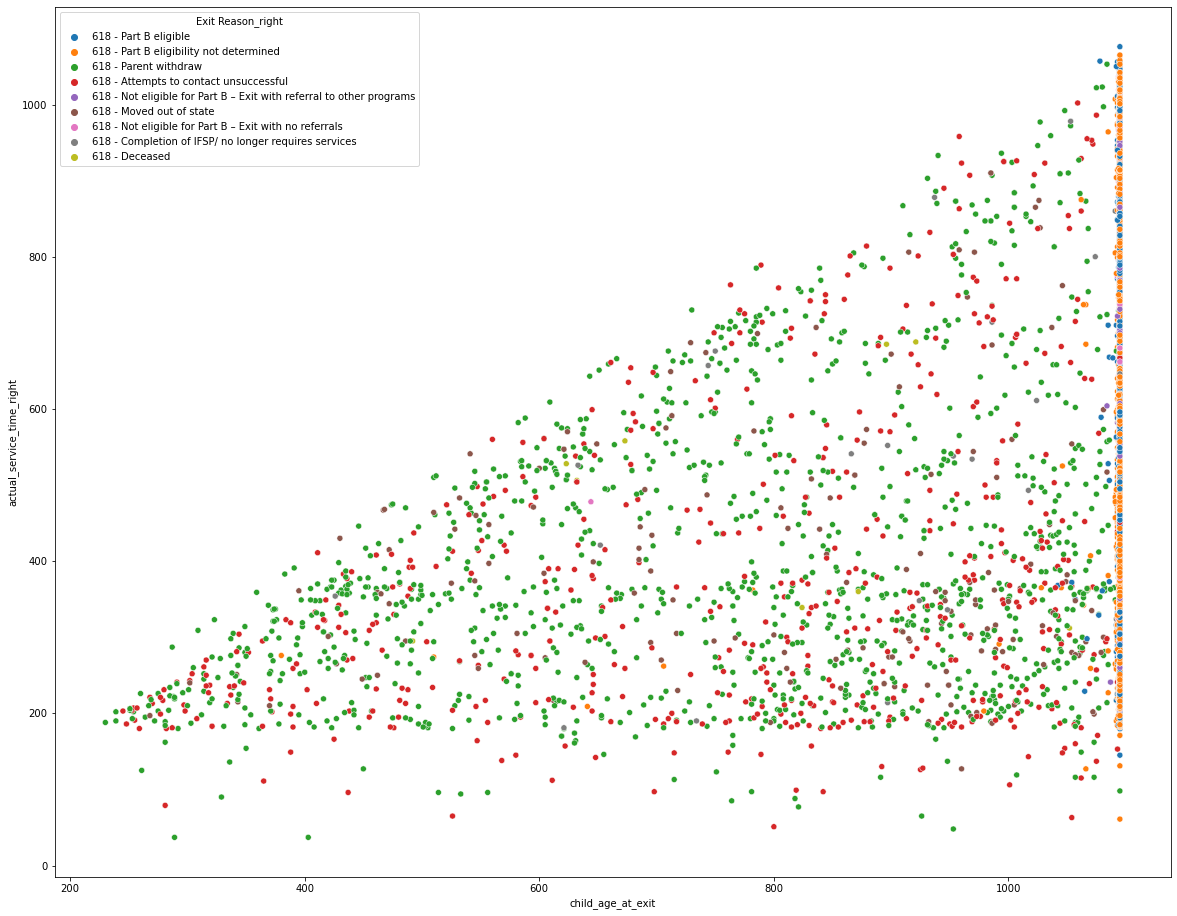

In [12]:
calc_merge['child_age_at_exit'] = calc_merge['Exit Date_left'] - calc_merge['DOB_left']
calc_merge.child_age_at_exit = calc_merge.child_age_at_exit.astype(str).str.replace(' days', '').astype(int)
calc_merge.actual_service_time_right = np.where(calc_merge.actual_service_time_right > calc_merge.child_age_at_exit, calc_merge.child_age_at_exit, calc_merge.actual_service_time_right)

plt.figure(figsize = (20,16))

sns.scatterplot(data = calc_merge,
                x = 'child_age_at_exit',
                y = 'actual_service_time_right',
                hue = 'Exit Reason_right')